In [1]:
#import libraries

import os
import time
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dense, LayerNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
#load data
df = pd.read_csv('../local/FibroPredCODIFICADA.csv')
df = df[:-1]
df.drop(columns=['COD NUMBER'], inplace=True)

In [3]:
#data preprocessing
data_info = {
    "head": df.head(),
    "info": df.info(),
    "description": df.describe(),
    "columns": df.columns.tolist(),
}
data_info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222 entries, 0 to 221
Data columns (total 76 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Pedigree                                       222 non-null    float64
 1   Sex                                            222 non-null    object 
 2   FamilialvsSporadic                             222 non-null    object 
 3   Age at diagnosis                               221 non-null    float64
 4   Binary diagnosis                               222 non-null    object 
 5   Final diagnosis                                222 non-null    float64
 6   TOBACCO                                        222 non-null    float64
 7   Detail                                         66 non-null     object 
 8   Comorbidities                                  222 non-null    float64
 9   Radiological Pattern                           221 non

{'head':    Pedigree     Sex FamilialvsSporadic  Age at diagnosis Binary diagnosis  \
 0       1.0    Male           Familial              70.0           No IPF   
 1       2.0    Male           Familial              66.0           No IPF   
 2       3.0    Male           Familial              59.0           No IPF   
 3       4.0  Female           Familial              66.0              IPF   
 4       5.0    Male           Familial              72.0              IPF   
 
    Final diagnosis  TOBACCO              Detail  Comorbidities  \
 0              3.0      2.0  Tobacco-associated            0.0   
 1              8.0      2.0                 NaN            1.0   
 2              3.0      2.0  Tobacco-associated            0.0   
 3              1.0      0.0          Organizing            1.0   
 4              1.0      0.0                 NaN            1.0   
 
   Radiological Pattern  ...                   Type of family history  \
 0                  UIP  ...                 

In [4]:
# Check unique values in specific columns
unique_values = {
    "Death": df["Death"].unique(),
    "Necessity of transplantation": df["Necessity of transplantation"].unique(),
    "Progressive disease": df["Progressive disease"].unique()
}

unique_values

{'Death': array(['Yes', 'No', nan], dtype=object),
 'Necessity of transplantation': array([ 0.,  1., nan]),
 'Progressive disease': array([ 1.,  0., nan])}

In [5]:
missing_values_rows = df[df[['Death', 'Necessity of transplantation', 'Progressive disease']].isnull().any(axis=1)]
missing_values_rows

,Pedigree,Sex,FamilialvsSporadic,Age at diagnosis,Binary diagnosis,Final diagnosis,TOBACCO,Detail,Comorbidities,Radiological Pattern,...,Type of family history,1st degree relative,2nd degree relative,More than 1 relative,Genetic mutation studied in patient,Mutation Type,Severity of telomere shortening,Severity of telomere shortening - Transform 4,Progressive disease,ProgressiveDisease
22,13.0,Male,Familial,81.0,IPF,1.0,0.0,NaN,1.0,UIP,...,IPF (2),1.0,0.0,0.0,1.0,NaN,3.0,6.0,NaN,NaN
48,26.0,Female,Familial,63.0,No IPF,4.0,2.0,Tobacco-associated,1.0,Non UIP,...,Unspecified PF,1.0,0.0,1.0,1.0,NaN,1.0,4.0,NaN,NaN
49,27.0,Female,Familial,64.0,IPF,1.0,0.0,NaN,1.0,Indeterminate UIP,...,IPF,1.0,0.0,0.0,0.0,NaN,1.0,4.0,NaN,NaN
50,28.0,Female,Familial,62.0,No IPF,17.0,0.0,NaN,1.0,Non UIP,...,Intersticial Pneumonia,1.0,0.0,0.0,0.0,NaN,1.0,4.0,NaN,NaN
54,31.0,Female,Familial,70.0,IPF,1.0,0.0,NaN,1.0,Indeterminate UIP,...,"CHP, Unspecified PF",1.0,1.0,1.0,1.0,NaN,1.0,4.0,NaN,NaN
73,45.0,Male,Familial,53.0,No IPF,11.0,2.0,RA,0.0,Probable UIP,...,Unspecified PF,1.0,1.0,1.0,1.0,NaN,2.0,5.0,NaN,NaN
74,46.0,Female,Familial,62.0,IPF,1.0,0.0,NaN,0.0,Indeterminate UIP,...,Unspecified PF,1.0,0.0,1.0,1.0,NaN,2.0,5.0,NaN,NaN
77,48.0,Male,Familial,51.0,No IPF,2.0,2.0,NaN,0.0,UIP,...,IPF,1.0,1.0,1.0,1.0,NaN,1.0,4.0,NaN,NaN
119,0.0,Male,Sporadic,82.0,IPF,1.0,2.0,NaN,1.0,UIP,...,No history,0.0,0.0,0.0,1.0,NaN,2.0,5.0,0.0,0.0
121,0.0,Male,Sporadic,78.0,IPF,1.0,0.0,NaN,0.0,UIP,...,No history,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0


In [6]:
# Drop columns of liters of FVC and DLCO
df.drop(columns=['FVC (L) at diagnosis', 'FVC (L) 1 year after diagnosis'], inplace=True)

# Add new columns for the difference in percentages
df['FVC absolute'] = df['FVC (%) 1 year after diagnosis'] - df['FVC (%) at diagnosis']
df['DLCO absolute'] = df['DLCO (%) 1 year after diagnosis'] - df['DLCO (%) at diagnosis']

# Display the updated dataframe
df.drop(columns=['FVC (%) 1 year after diagnosis', 'DLCO (%) 1 year after diagnosis', 'FVC (%) at diagnosis', 'DLCO (%) at diagnosis'], inplace=True)

In [7]:
# Add new binary columns based on the conditions
df['FVC binary'] = np.where(df['FVC absolute'] <= -5, 1, 0)
df['DLCO binary'] = np.where(df['DLCO absolute'] <= -10, 1, 0)

# Drop the absolute columns
df.drop(columns=['FVC absolute', 'DLCO absolute'], inplace=True)

# Display the updated dataframe
df.head()

,Pedigree,Sex,FamilialvsSporadic,Age at diagnosis,Binary diagnosis,Final diagnosis,TOBACCO,Detail,Comorbidities,Radiological Pattern,...,2nd degree relative,More than 1 relative,Genetic mutation studied in patient,Mutation Type,Severity of telomere shortening,Severity of telomere shortening - Transform 4,Progressive disease,ProgressiveDisease,FVC binary,DLCO binary
0,1.0,Male,Familial,70.0,No IPF,3.0,2.0,Tobacco-associated,0.0,UIP,...,0.0,0.0,1.0,NaN,3.0,6.0,1.0,1.0,1,1
1,2.0,Male,Familial,66.0,No IPF,8.0,2.0,NaN,1.0,Probable UIP,...,0.0,1.0,1.0,NaN,1.0,4.0,1.0,1.0,1,0
2,3.0,Male,Familial,59.0,No IPF,3.0,2.0,Tobacco-associated,0.0,UIP,...,0.0,0.0,1.0,NaN,3.0,6.0,1.0,1.0,0,0
3,4.0,Female,Familial,66.0,IPF,1.0,0.0,Organizing,1.0,Non UIP,...,0.0,0.0,0.0,NaN,4.0,3.0,1.0,1.0,1,1
4,5.0,Male,Familial,72.0,IPF,1.0,0.0,NaN,1.0,Probable UIP,...,0.0,1.0,1.0,TERT Exon 2b/HT/c.835G>A / p.Ala279Thr/ rs6174...,3.0,6.0,1.0,1.0,0,1


In [8]:
# Create the new column 'fibrosis progression' based on the OR condition
df['fibrosis progression'] = df[['FVC binary', 'DLCO binary', 'RadioWorsening2y']].any(axis=1).astype(int)

# Drop the specified columns
df.drop(columns=['FVC binary', 'DLCO binary', 'RadioWorsening2y'], inplace=True)
# Display the updated dataframe
df.head()

,Pedigree,Sex,FamilialvsSporadic,Age at diagnosis,Binary diagnosis,Final diagnosis,TOBACCO,Detail,Comorbidities,Radiological Pattern,...,1st degree relative,2nd degree relative,More than 1 relative,Genetic mutation studied in patient,Mutation Type,Severity of telomere shortening,Severity of telomere shortening - Transform 4,Progressive disease,ProgressiveDisease,fibrosis progression
0,1.0,Male,Familial,70.0,No IPF,3.0,2.0,Tobacco-associated,0.0,UIP,...,1.0,0.0,0.0,1.0,NaN,3.0,6.0,1.0,1.0,1
1,2.0,Male,Familial,66.0,No IPF,8.0,2.0,NaN,1.0,Probable UIP,...,1.0,0.0,1.0,1.0,NaN,1.0,4.0,1.0,1.0,1
2,3.0,Male,Familial,59.0,No IPF,3.0,2.0,Tobacco-associated,0.0,UIP,...,1.0,0.0,0.0,1.0,NaN,3.0,6.0,1.0,1.0,1
3,4.0,Female,Familial,66.0,IPF,1.0,0.0,Organizing,1.0,Non UIP,...,1.0,0.0,0.0,0.0,NaN,4.0,3.0,1.0,1.0,1
4,5.0,Male,Familial,72.0,IPF,1.0,0.0,NaN,1.0,Probable UIP,...,1.0,0.0,1.0,1.0,TERT Exon 2b/HT/c.835G>A / p.Ala279Thr/ rs6174...,3.0,6.0,1.0,1.0,1


In [9]:
df['fibrosis progression'].value_counts()

fibrosis progression
1    112
0    110
Name: count, dtype: int64

In [10]:
df['Detail'].value_counts()

Detail
Aviary                19
Unknown               12
Tobacco-associated    11
RA                     8
Incipient              5
Aviary, Fungi          4
Fungi                  2
Organizing             1
RA-SLE                 1
Anti-synthetase        1
Farmer's lung          1
Humidity               1
Name: count, dtype: int64

In [11]:


df.drop(columns=['Detail'], inplace=True)

In [12]:
df.drop(columns=['Severity of telomere shortening - Transform 4'], inplace=True)

In [13]:
# Check for specific 'NON UIP' values in 'Radiological Pattern' column
non_uip_values = df[df['Radiological Pattern'] == 'Non UIP']
non_uip_values

,Pedigree,Sex,FamilialvsSporadic,Age at diagnosis,Binary diagnosis,Final diagnosis,TOBACCO,Comorbidities,Radiological Pattern,Detail on NON UIP,...,Type of family history,1st degree relative,2nd degree relative,More than 1 relative,Genetic mutation studied in patient,Mutation Type,Severity of telomere shortening,Progressive disease,ProgressiveDisease,fibrosis progression
3,4.0,Female,Familial,66.0,IPF,1.0,0.0,1.0,Non UIP,Fibrosing Organizing Pneumonia,...,NaN,1.0,0.0,0.0,0.0,NaN,4.0,1.0,1.0,1
5,5.0,Male,Familial,64.0,IPF,1.0,2.0,1.0,Non UIP,NaN,...,"IPF, GPA, IPAF",1.0,0.0,1.0,1.0,TERT Exon 2b/HT/c.835G>A / p.Ala279Thr/ rs6174...,3.0,0.0,0.0,1
6,5.0,Female,Familial,49.0,No IPF,9.0,0.0,0.0,Non UIP,NaN,...,"IPF, Dendriform ossification, IPAF",1.0,0.0,1.0,1.0,TERT Exon 2b/HT/c.835G>A / p.Ala279Thr/ rs6174...,1.0,0.0,0.0,0
10,6.0,Male,Familial,38.0,No IPF,5.0,0.0,0.0,Non UIP,NaN,...,IPF,1.0,0.0,0.0,1.0,TERT,3.0,1.0,1.0,1
13,7.0,Male,Familial,39.0,No IPF,5.0,0.0,0.0,Non UIP,NaN,...,"IPF, Unspecified PF",1.0,0.0,1.0,1.0,TERT,3.0,1.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,0.0,Female,Sporadic,63.0,No IPF,6.0,0.0,1.0,Non UIP,Trapping,...,No history,0.0,0.0,0.0,NaN,NaN,NaN,1.0,1.0,1
217,0.0,Female,Sporadic,76.0,No IPF,6.0,0.0,1.0,Non UIP,NaN,...,No history,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0
218,0.0,Female,Sporadic,76.0,No IPF,6.0,2.0,1.0,Non UIP,NaN,...,No history,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0
219,0.0,Female,Sporadic,79.0,No IPF,6.0,0.0,1.0,Non UIP,NaN,...,No history,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0


In [14]:
df.drop(columns=['Extra', 'Extras AP'], inplace=True)

In [15]:
df.drop(columns=['Pedigree', '1st degree relative', '2nd degree relative', 'More than 1 relative', 'Type of family history'], inplace=True)

In [16]:
df['familiar aggregation'] = df['FamilialvsSporadic'].apply(lambda x: 1 if x == 'Familial' else 0)
df.drop(columns=['FamilialvsSporadic'], inplace=True)

In [17]:
# Función para determinar la presencia del patrón UIP considerando todas las columnas relevantes
def determine_uip(row):
    # Extraer información de las columnas relevantes
    radiological = row['Radiological Pattern']
    detail_non_uip = row['Detail on NON UIP']
    pathology_chp = row['Pathology pattern UIP, probable or CHP']
    pathology_binary = row['Pathology Pattern Binary']
    biopsy = row['Biopsy']
    pathology_pattern = row['Pathology pattern']
    
    # Definir la presencia del patrón UIP basado en las reglas
    if (
        radiological in ['UIP', 'Probable UIP'] or 
        pathology_chp in ['UIP', 'Probable UIP'] or 
        pathology_binary == 'UIP' or 
        pathology_pattern in ['UIP', 'Probable UIP']
    ):
        return 1  # UIP presente
    elif (
        radiological == 'Non UIP' or 
        pathology_chp == 'CHP' or 
        pathology_binary == 'NON UIP' or 
        detail_non_uip in ['Fibrosing Organizing Pneumonia', 'CHP', 'Sarcoidosis IV'] or 
        pathology_pattern in ['CHP', 'NSIP', 'AFOP']
    ):
        return 0  # UIP ausente
    elif biopsy in [0, 2]:
        return 0  # Ausencia confirmada por biopsia negativa o no realizada
    return None  # Desconocido/indeterminado

# Aplicar la función a cada fila del DataFrame
df['UIP_Pattern'] = df.apply(determine_uip, axis=1)

# Verificar la distribución de la nueva columna
df['UIP_Pattern'].value_counts(dropna=True)

UIP_Pattern
1.0    140
0.0     80
Name: count, dtype: int64

In [18]:
def create_mpid_score(df):
    # Inicializar columna de puntuación
    df['mpid_score'] = 0
 
    # 1. Puntuación por mutaciones genéticas (peso mayor por ser más definitorio)
    df['genetic_score'] = 0
    mutation_types = {
        'TERT': 5,
        'TERC': 5,
        'PARN': 5,
        'DKC1': 5,
        'RTEL1': 5
    }
 
    for mutation, score in mutation_types.items():
        mask = df['Mutation Type'].str.contains(mutation, na=False)
        df.loc[mask, 'genetic_score'] = score
 
    # 2. Puntuación por manifestaciones extrapulmonares (peso intermedio)
    df['extrapulmonary_score'] = 0
    if df['Extrapulmonary affectation'].eq(1).any():
        df.loc[df['Extrapulmonary affectation'] == 1, 'extrapulmonary_score'] = 3
 
    # 3. Puntuación por alteraciones hematológicas (peso intermedio)
    df['hematological_score'] = 0
    hematological_conditions = [
        'Anemia', 'Thrombocytopenia', 'Thrombocytosis',
        'Lymphocytosis', 'Lymphopenia', 'Neutrophilia',
        'Neutropenia', 'Leukocytosis', 'Leukopenia'
    ]
 
    for condition in hematological_conditions:
        df.loc[df[condition] == 1, 'hematological_score'] += 2
 
    # 4. Puntuación por alteraciones hepáticas (peso intermedio)
    df['liver_score'] = 0
    if df['Liver abnormality'].eq(1).any():
        df.loc[df['Liver abnormality'] == 1, 'liver_score'] = 2
 
    # 5. Puntuación por severidad del acortamiento telomérico (peso alto)
    df['telomere_score'] = 0
    df.loc[df['Severity of telomere shortening'] >= 5, 'telomere_score'] = 4
    df.loc[df['Severity of telomere shortening'].between(3, 4), 'telomere_score'] = 2
    df.loc[df['Severity of telomere shortening'] <= 2, 'telomere_score'] = 1
 
    # Calcular puntuación total
    df['mpid_score'] = (df['genetic_score'] + 
                       df['telomere_score'])
 
    # Clasificar tipos de MPID basado en la puntuación total
    df['MPID_type'] = 'No MPID'
    df.loc[df['mpid_score'] >= 8, 'MPID_type'] = 'Severe MPID'
    df.loc[df['mpid_score'].between(4, 7), 'MPID_type'] = 'Moderate MPID'
    df.loc[df['mpid_score'].between(1, 3), 'MPID_type'] = 'Mild MPID'
 
    return df
 
# Aplicar la función al dataframe
def process_data(sigma_df):
 
    df_processed = create_mpid_score(sigma_df)
 
    # Mostrar distribución de tipos de MPID
    print("\nDistribución de tipos de MPID:")
    print(df_processed['MPID_type'].value_counts())
 
    # Mostrar estadísticas descriptivas de las puntuaciones
    print("\nEstadísticas de puntuaciones:")
    score_columns = ['mpid_score', 'genetic_score', 'extrapulmonary_score', 
                    'hematological_score', 'liver_score', 'telomere_score']
    print(df_processed[score_columns].describe())
 
    return df_processed
 
# Usar la función
df = process_data(df)


Distribución de tipos de MPID:
MPID_type
Mild MPID        112
No MPID           70
Moderate MPID     38
Severe MPID        2
Name: count, dtype: int64

Estadísticas de puntuaciones:
       mpid_score  genetic_score  extrapulmonary_score  hematological_score  \
count  222.000000     222.000000            222.000000           222.000000   
mean     1.774775       0.518018              0.418919             0.810811   
std      1.998573       1.527172              1.042188             1.542833   
min      0.000000       0.000000              0.000000             0.000000   
25%      0.000000       0.000000              0.000000             0.000000   
50%      1.000000       0.000000              0.000000             0.000000   
75%      2.000000       0.000000              0.000000             2.000000   
max      9.000000       5.000000              3.000000             8.000000   

       liver_score  telomere_score  
count        222.0      222.000000  
mean           0.0        1.256

In [19]:
# Create the new column 'aguditatzcions' based on the conditions
df['aguditzacions'] = df['Cause of death'].apply(lambda x: 0 if x == 'No death' or pd.isna(x) else 1)

# Display the updated dataframe
df.head()

,Sex,Age at diagnosis,Binary diagnosis,Final diagnosis,TOBACCO,Comorbidities,Radiological Pattern,Detail on NON UIP,Biopsy,Pathology Pattern Binary,...,familiar aggregation,UIP_Pattern,mpid_score,genetic_score,extrapulmonary_score,hematological_score,liver_score,telomere_score,MPID_type,aguditzacions
0,Male,70.0,No IPF,3.0,2.0,0.0,UIP,NaN,0.0,NaN,...,1,1.0,2,0,0,0,0,2,Mild MPID,1
1,Male,66.0,No IPF,8.0,2.0,1.0,Probable UIP,NaN,0.0,NON UIP,...,1,1.0,1,0,0,4,0,1,Mild MPID,0
2,Male,59.0,No IPF,3.0,2.0,0.0,UIP,NaN,1.0,UIP,...,1,1.0,2,0,0,0,0,2,Mild MPID,0
3,Female,66.0,IPF,1.0,0.0,1.0,Non UIP,Fibrosing Organizing Pneumonia,1.0,UIP,...,1,1.0,2,0,3,4,0,2,Mild MPID,1
4,Male,72.0,IPF,1.0,0.0,1.0,Probable UIP,NaN,0.0,NaN,...,1,1.0,7,5,3,0,0,2,Moderate MPID,0


In [20]:
# # Create the new column 'antiinflamatoris' based on the OR condition
# df['antiinflamatoris'] = np.where((df['Prednisone'] == 1) | (df['Mycophenolate'] == 1), 1, 0)

# # Replace 0 with NaN
# df['antiinflamatoris'].replace(np.nan, 0 , inplace=True)

# # Display the updated dataframe
# df.head()

In [21]:
# Create the new column 'Cancer' based on the conditions

# Replace NaN values with 0

# Display the updated dataframe

df['Associated lung cancer'].fillna(0, inplace=True)
df['Other cancer'].fillna(0, inplace=True)

C:\Users\javil\AppData\Local\Temp\ipykernel_4164\1897971570.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Associated lung cancer'].fillna(0, inplace=True)
C:\Users\javil\AppData\Local\Temp\ipykernel_4164\1897971570.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For e

In [22]:
df['Progressive disease'].fillna(0, inplace=True)
df['Genetic mutation studied in patient'].fillna(0, inplace=True)
df['Mutation Type'].replace(-9, 0, inplace=True)
df['Death'].fillna('No', inplace=True)

C:\Users\javil\AppData\Local\Temp\ipykernel_4164\371537455.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Progressive disease'].fillna(0, inplace=True)
C:\Users\javil\AppData\Local\Temp\ipykernel_4164\371537455.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exampl

In [23]:
df['Death'].value_counts()

Death
No     179
Yes     43
Name: count, dtype: int64

In [24]:
# Cambiar valores en las columnas 'Liver disease' y 'Hematologic Disease'
df['Liver disease'] = df['Liver disease'].apply(lambda x: 0 if x == 'No' else 1).fillna(0).astype(int)
df['Hematologic Disease'] = df['Hematologic Disease'].apply(lambda x: 0 if x == 'No' else 1).fillna(0).astype(int)

# Crear la nueva columna 'Has_liver_disease'

In [25]:
# Create a new DataFrame with the specified columns
new_df = df[['fibrosis progression', 'TOBACCO', 'familiar aggregation', 'Comorbidities', 'Sex', 'Age at diagnosis', 'Genetic mutation studied in patient', 'Death', 'Progressive disease', 'Necessity of transplantation','UIP_Pattern', 'MPID_type', 'aguditzacions', 'Antifibrotic Drug', 'Associated lung cancer', 'Other cancer','Liver disease', 'Hematologic Disease']]

# Display the new DataFrame
new_df.columns

Index(['fibrosis progression', 'TOBACCO', 'familiar aggregation',
       'Comorbidities', 'Sex', 'Age at diagnosis',
       'Genetic mutation studied in patient', 'Death', 'Progressive disease',
       'Necessity of transplantation', 'UIP_Pattern', 'MPID_type',
       'aguditzacions', 'Antifibrotic Drug', 'Associated lung cancer',
       'Other cancer', 'Liver disease', 'Hematologic Disease'],
      dtype='object')

In [26]:
new_df.dropna(subset=['Age at diagnosis'], inplace=True)


C:\Users\javil\AppData\Local\Temp\ipykernel_4164\3363846184.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.dropna(subset=['Age at diagnosis'], inplace=True)


In [27]:
import openpyxl
import sys
import os

# Ruta del archivo que deseas eliminar
file_path = "../local/new_df.xlsx"

# Verificar si el archivo existe y eliminarlo
if os.path.exists(file_path):
    os.remove(file_path)  # Elimina el archivo
    
else:
    print(f"El archivo '{file_path}' no existe.")
# Save the DataFrame to an Excel file, replacing the existing file
new_df.to_excel(file_path, index=False)

In [28]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder instance
label_encoder = LabelEncoder()

# List of columns to encode, excluding 'Age at diagnosis'
columns_to_encode = new_df.columns.difference(['Age at diagnosis'])
# Apply label encoding to each column
for column in columns_to_encode:
    new_df[column] = label_encoder.fit_transform(new_df[column])

bins = [0, 60 ,70, 80, 100]
labels = [0, 1, 2, 3]
new_df['Age at diagnosis'] = pd.cut(new_df['Age at diagnosis'], bins=bins, labels=labels, right=False).astype(int)
# Display the updated dataframe

new_df.head()

C:\Users\javil\AppData\Local\Temp\ipykernel_4164\1669921553.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df[column] = label_encoder.fit_transform(new_df[column])
C:\Users\javil\AppData\Local\Temp\ipykernel_4164\1669921553.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df[column] = label_encoder.fit_transform(new_df[column])
C:\Users\javil\AppData\Local\Temp\ipykernel_4164\1669921553.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

,fibrosis progression,TOBACCO,familiar aggregation,Comorbidities,Sex,Age at diagnosis,Genetic mutation studied in patient,Death,Progressive disease,Necessity of transplantation,UIP_Pattern,MPID_type,aguditzacions,Antifibrotic Drug,Associated lung cancer,Other cancer,Liver disease,Hematologic Disease
0,1,2,1,0,1,2,2,1,1,0,1,0,1,1,0,0,0,0
1,1,2,1,1,1,1,2,0,1,0,1,0,0,1,0,1,0,0
2,1,2,1,0,1,0,2,0,1,1,1,0,0,1,0,0,0,0
3,1,0,1,1,0,1,1,1,1,0,1,0,1,1,1,0,0,0
4,1,0,1,1,1,2,2,0,1,0,1,1,0,1,0,0,0,1


In [29]:
new_df_death = new_df.copy()
new_df_progressive_disease = new_df.copy()
new_df_necessity_transpl = new_df.copy()

In [30]:
new_df['Antifibrotic Drug'].value_counts()

Antifibrotic Drug
1    129
0     92
Name: count, dtype: int64

In [31]:
from sklearn.ensemble import GradientBoostingClassifier


gbt = GradientBoostingClassifier()

# Drop unnecessary columns
new_df_necessity_transpl.drop(columns=['Death', 'Progressive disease'], inplace=True)
new_df_death.drop(columns=['Necessity of transplantation', 'Progressive disease'], inplace=True)
new_df_progressive_disease.drop(columns=['Death', 'Necessity of transplantation'], inplace=True)

# Fit the GradientBoostingClassifier model
X_transpl = new_df_necessity_transpl.drop(columns=['Necessity of transplantation'])
y_transpl = new_df_necessity_transpl['Necessity of transplantation']
X_death = new_df_death.drop(columns=['Death'])
y_death = new_df_death['Death']
X_progressive = new_df_progressive_disease.drop(columns=['Progressive disease'])
y_progressive = new_df_progressive_disease['Progressive disease']

gbt.fit(X_transpl, y_transpl)

# Determine feature importances
feature_importances_transpl = gbt.feature_importances_

# Create a DataFrame for feature importances
feature_importances_df_transpl = pd.DataFrame({
    'Feature': X_transpl.columns,
    'Importance': feature_importances_transpl
}).sort_values(by='Importance', ascending=False)

gbt.fit(X_death, y_death)

# Determine feature importances
feature_importances_death = gbt.feature_importances_

# Create a DataFrame for feature importances
feature_importances_df_death = pd.DataFrame({
    'Feature': X_death.columns,
    'Importance': feature_importances_death
}).sort_values(by='Importance', ascending=False)

gbt.fit(X_progressive, y_progressive)
feature_importances_progressive = gbt.feature_importances_

# Create a DataFrame for feature importances
feature_importances_df_progressive = pd.DataFrame({
    'Feature': X_progressive.columns,
    'Importance': feature_importances_progressive
}).sort_values(by='Importance', ascending=False)

feature_importances_df_transpl, feature_importances_df_death, feature_importances_df_progressive





(                                Feature  Importance
 5                      Age at diagnosis    0.320432
 8                             MPID_type    0.143814
 0                  fibrosis progression    0.128765
 7                           UIP_Pattern    0.092149
 1                               TOBACCO    0.054119
 10                    Antifibrotic Drug    0.050952
 2                  familiar aggregation    0.034133
 9                         aguditzacions    0.033267
 3                         Comorbidities    0.027184
 14                  Hematologic Disease    0.025701
 4                                   Sex    0.021717
 13                        Liver disease    0.020053
 11               Associated lung cancer    0.019352
 6   Genetic mutation studied in patient    0.018368
 12                         Other cancer    0.009995,
                                 Feature  Importance
 9                         aguditzacions    0.927252
 0                  fibrosis progression    0

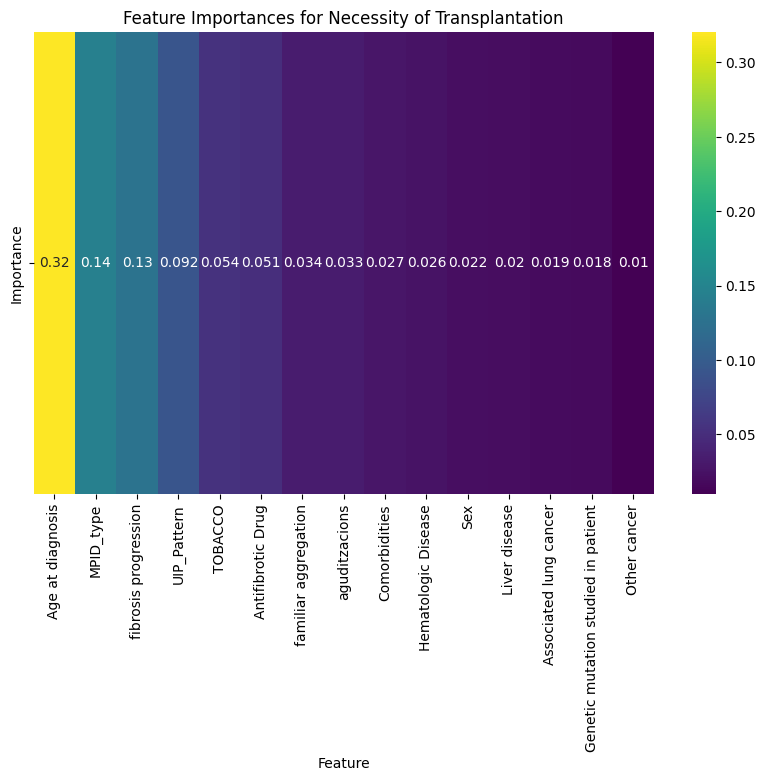

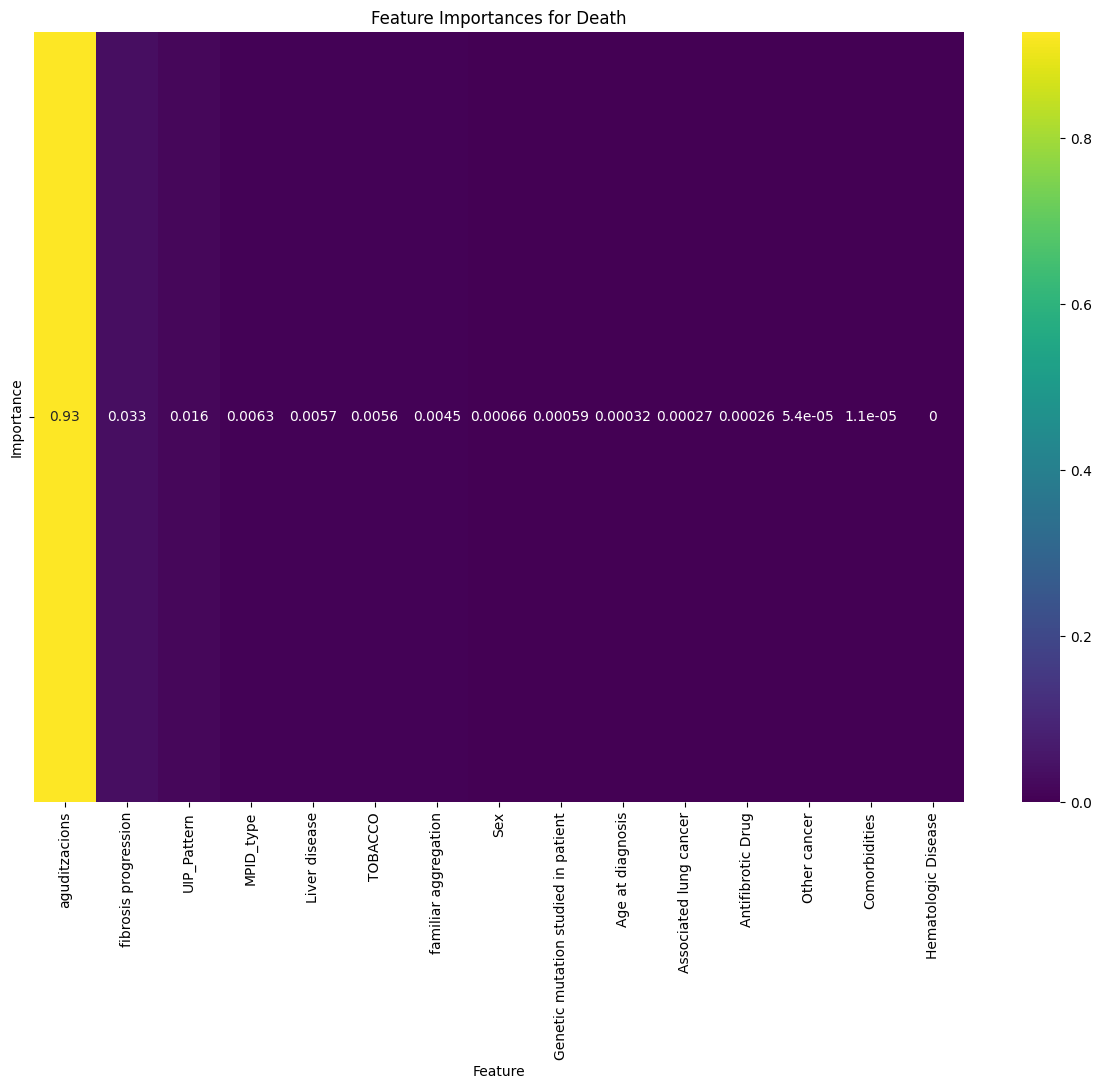

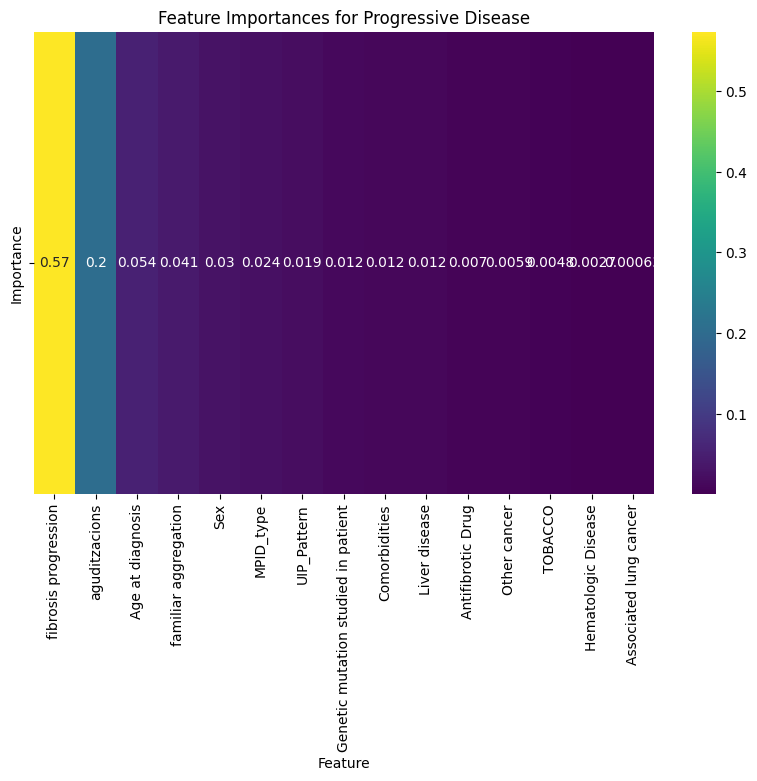

In [32]:
import seaborn as sns

import matplotlib.pyplot as plt

# Plot heatmap for feature importances of transplantation
plt.figure(figsize=(10, 6))
sns.heatmap(feature_importances_df_transpl.set_index('Feature').T, annot=True, cmap='viridis')
plt.title('Feature Importances for Necessity of Transplantation')
plt.show()

# Plot heatmap for feature importances of death
plt.figure(figsize=(15, 10))
sns.heatmap(feature_importances_df_death.set_index('Feature').T, annot=True, cmap='viridis')
plt.title('Feature Importances for Death')
plt.show()
#bigger


# Plot heatmap for feature importances of progressive disease
plt.figure(figsize=(10, 6))
sns.heatmap(feature_importances_df_progressive.set_index('Feature').T, annot=True, cmap='viridis')
plt.title('Feature Importances for Progressive Disease')
plt.show()


In [33]:
# mergear las tres training databases

transpl = X_transpl.merge(y_transpl, left_index=True, right_index=True)
death = X_death.merge(y_death, left_index=True, right_index=True)
progressive = X_progressive.merge(y_progressive, left_index=True, right_index=True)


In [34]:
# descargar bases de datos para guardar en local

transpl.to_csv('../local/tranpl_training.csv', index=False)
death.to_csv('../local/death_training.csv', index=False)
progressive.to_csv('../local/progressive_training.csv', index=False)

In [35]:
# Count the number of columns for each DataFrame
num_columns_transpl = transpl.shape[1]
num_columns_death = death.shape[1]
num_columns_progressive = progressive.shape[1]

death.columns

Index(['fibrosis progression', 'TOBACCO', 'familiar aggregation',
       'Comorbidities', 'Sex', 'Age at diagnosis',
       'Genetic mutation studied in patient', 'UIP_Pattern', 'MPID_type',
       'aguditzacions', 'Antifibrotic Drug', 'Associated lung cancer',
       'Other cancer', 'Liver disease', 'Hematologic Disease', 'Death'],
      dtype='object')

In [36]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib  # Para guardar y cargar los escaladores
import pandas as pd
import wandb

# 1. Cargar los datos desde archivos CSV
death_data = pd.read_csv("../local/death_training.csv")
transplant_data = pd.read_csv("../local/tranpl_training.csv")
progressive_data = pd.read_csv("../local/progressive_training.csv")

# 2. Separar características (X) y etiquetas (y) para cada caso
X_death = death_data.iloc[:, :-1].values  # Primeras 15 columnas
y_death = death_data.iloc[:, -1].values   # Columna de la variable objetivo

X_transplant = transplant_data.iloc[:, :-1].values  # Primeras 15 columnas
y_transplant = transplant_data.iloc[:, -1].values   # Columna de la variable objetivo

X_progressive = progressive_data.iloc[:, :-1].values  # Primeras 16 columnas
y_progressive = progressive_data.iloc[:, -1].values   # Columna de la variable objetivo

# 3. Preprocesamiento para dividir conjuntos y normalizar
def prepare_data(X, y, num_features, scaler_filename):
    X_train, X_test, y_train, y_test = train_test_split(X[:, :num_features], y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    joblib.dump(scaler, f"../local/scalers/{scaler_filename}")  # Guardar el escalador
    return X_train, X_test, y_train, y_test

# Preparar los datos para cada modelo
X_death_train, X_death_test, y_death_train, y_death_test = prepare_data(
    X_death, y_death, 15, "death_scaler.pkl"
)
X_transplant_train, X_transplant_test, y_transplant_train, y_transplant_test = prepare_data(
    X_transplant, y_transplant, 15, "transplant_scaler.pkl"
)
X_progressive_train, X_progressive_test, y_progressive_train, y_progressive_test = prepare_data(
    X_progressive, y_progressive, 15, "progressive_scaler.pkl"
)

# 4. Crear una red neuronal
def create_model(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim),  # Capa de entrada
        Dense(32, activation='relu'),                      # Capa oculta
        Dense(1, activation='sigmoid')                     # Capa de salida para probabilidad
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Entrenamiento y guardado de modelos:
wandb.init(project="FibroPred-Models1")

# Modelo para "death"
death_run = wandb.init(project="FibroPred-Models1", name="Death Model Training")
print("\nEntrenando modelo para 'Death'...\n")
model_death = create_model(15)
death = model_death.fit(X_death_train, y_death_train, epochs=20, batch_size=16, validation_split=0.2, verbose=1)
for epoch in range(len(death.history['loss'])):
    wandb.log({
        "epoch": epoch + 1,
        "death_loss": death.history['loss'][epoch],
        "death_accuracy": death.history['accuracy'][epoch],
        "death_val_loss": death.history['val_loss'][epoch],
        "death_val_accuracy": death.history['val_accuracy'][epoch]
    })
model_death.save("../local/models/model_death.h5")
death_loss, death_accuracy = model_death.evaluate(X_death_test, y_death_test)
print(f"Death Model - Loss: {death_loss}, Accuracy: {death_accuracy}")
death_run.finish()

# Modelo para "transplant"
transplant_run = wandb.init(project="FibroPred-Models1", name="Transplant Model Training")
print("\nEntrenando modelo para 'Transplant'...\n")
model_transplant = create_model(15)
hist_transplant = model_transplant.fit(X_transplant_train, y_transplant_train, epochs=20, batch_size=16, validation_split=0.2, verbose=1)
for epoch in range(len(hist_transplant.history['loss'])):
    wandb.log({
        "epoch": epoch + 1,
        "transplant_loss": hist_transplant.history['loss'][epoch],
        "transplant_accuracy": hist_transplant.history['accuracy'][epoch],
        "transplant_val_loss": hist_transplant.history['val_loss'][epoch],
        "transplant_val_accuracy": hist_transplant.history['val_accuracy'][epoch]
    })
model_transplant.save("../local/models/model_transplant.h5")
transplant_loss, transplant_accuracy = model_transplant.evaluate(X_transplant_test, y_transplant_test)
print(f"Transplant Model - Loss: {transplant_loss}, Accuracy: {transplant_accuracy}")
transplant_run.finish()

# Modelo para "progressive"
progressive_run = wandb.init(project="FibroPred-Models1", name="Progressive Disease Model Training")
print("\nEntrenando modelo para 'Progressive Disease'...\n")
model_progressive = create_model(15)
hist_progressive = model_progressive.fit(X_progressive_train, y_progressive_train, epochs=20, batch_size=16, validation_split=0.2, verbose=1)
for epoch in range(len(hist_progressive.history['loss'])):
    wandb.log({
        "epoch": epoch + 1,
        "progressive_loss": hist_progressive.history['loss'][epoch],
        "progressive_accuracy": hist_progressive.history['accuracy'][epoch],
        "progressive_val_loss": hist_progressive.history['val_loss'][epoch],
        "progressive_val_accuracy": hist_progressive.history['val_accuracy'][epoch]
    })
model_progressive.save("../local/models/model_progressive.h5")
progressive_loss, progressive_accuracy = model_progressive.evaluate(X_progressive_test, y_progressive_test)
print(f"Progressive Disease Model - Loss: {progressive_loss}, Accuracy: {progressive_accuracy}")
progressive_run.finish()

wandb.finish()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: javier-aranda (javier-aranda-universitat-polit-cnica-de-catalunya). Use `wandb login --relogin` to force relogin



Entrenando modelo para 'Death'...

Epoch 1/20


C:\Users\javil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3945 - loss: 0.7530 - val_accuracy: 0.6111 - val_loss: 0.6416
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7286 - loss: 0.6157 - val_accuracy: 0.8611 - val_loss: 0.5061
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8761 - loss: 0.4821 - val_accuracy: 0.8889 - val_loss: 0.4070
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8606 - loss: 0.4159 - val_accuracy: 0.9167 - val_loss: 0.3377
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9204 - loss: 0.3375 - val_accuracy: 0.9167 - val_loss: 0.2883
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9627 - loss: 0.2664 - val_accuracy: 0.9167 - val_loss: 0.2512
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9868 - loss: 0.2375 - val_accuracy: 0.9167 - val_loss: 0.2230
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9824 - loss: 0.1820 - val_accuracy: 0.9167 - val_loss: 0.2007
Epoch 9/20
9/9 ━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9748 - loss: 0.1345 
Death Model - Loss: 0.12146040797233582, Accuracy: 0.9777777791023254


death_accuracy,▁▅▆▇▇███████████████
death_loss,█▇▅▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁
death_val_accuracy,▁▆▇▇▇▇▇▇████████████
death_val_loss,█▆▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
death_accuracy,0.99286
death_loss,0.04114
death_val_accuracy,0.94444
death_val_loss,0.16337
epoch,20



Entrenando modelo para 'Transplant'...

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8519 - loss: 0.4788 - val_accuracy: 0.9167 - val_loss: 0.4190
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8236 - loss: 0.4430 - val_accuracy: 0.9167 - val_loss: 0.3955
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8659 - loss: 0.3620 - val_accuracy: 0.9167 - val_loss: 0.3870
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8717 - loss: 0.3174 - val_accuracy: 0.9167 - val_loss: 0.3833
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8322 - loss: 0.3392 - val_accuracy: 0.9167 - val_loss: 0.3901
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8487 - loss: 0.3306 - val_accuracy: 0.9167 - val_loss: 0.3923
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8484 - loss: 0.2853 - val_accuracy: 0.9167 - val_loss: 0.3965
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8562 - loss: 0.2722 - val_ac

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8354 - loss: 0.3243
Transplant Model - Loss: 0.3888666033744812, Accuracy: 0.800000011920929


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
transplant_accuracy,▁▁▁▁▁▁▁▁▂▃▃▃▄▅▆▇▇▇▇█
transplant_loss,█▇▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁▁
transplant_val_accuracy,████████▅▅▅▅▅▅▅▅▅▁▁▁
transplant_val_loss,▄▂▁▁▂▂▂▂▃▃▃▄▄▅▅▆▆▇▇█
epoch,20
transplant_accuracy,0.95
transplant_loss,0.15203
transplant_val_accuracy,0.86111
transplant_val_loss,0.47034



Entrenando modelo para 'Progressive Disease'...

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5945 - loss: 0.6569 - val_accuracy: 0.6667 - val_loss: 0.6116
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7647 - loss: 0.5885 - val_accuracy: 0.7778 - val_loss: 0.5618
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8056 - loss: 0.5272 - val_accuracy: 0.8333 - val_loss: 0.5229
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8211 - loss: 0.4907 - val_accuracy: 0.8056 - val_loss: 0.4863
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8424 - loss: 0.4421 - val_accuracy: 0.8333 - val_loss: 0.4617
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8850 - loss: 0.3921 - val_accuracy: 0.8333 - val_loss: 0.4408
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9285 - loss: 0.3495 - val_accuracy: 0.8333 - val_loss: 0.4151
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9276 - loss: 0.3107

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8947 - loss: 0.2119
Progressive Disease Model - Loss: 0.24169975519180298, Accuracy: 0.8888888955116272


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
progressive_accuracy,▁▄▅▅▆▆▇▇▇▇▇▇▇▇██████
progressive_loss,█▇▆▆▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁
progressive_val_accuracy,▁▆█▇███▇▆▆▆▆▇▇▆▇▇▆▇█
progressive_val_loss,█▇▆▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁
epoch,20
progressive_accuracy,0.96429
progressive_loss,0.16396
progressive_val_accuracy,0.83333
progressive_val_loss,0.36423


In [37]:
import numpy as np
import joblib
from tensorflow.keras.models import load_model

# Cargar los modelos guardados
model_death = load_model("../local/models/model_death.h5")
model_transplant = load_model("../local/models/model_transplant.h5")
model_progressive = load_model("../local/models/model_progressive.h5")

# Cargar los escaladores guardados
death_scaler = joblib.load("../local/scalers/death_scaler.pkl")
transplant_scaler = joblib.load("../local/scalers/transplant_scaler.pkl")
progressive_scaler = joblib.load("../local/scalers/progressive_scaler.pkl")

# Función para predecir solo la probabilidad correspondiente a cada entrada
def predict_single_probabilities(input_array, tasks):
    """
    Recibe un conjunto de entradas (input_arrays) y una lista de tareas (tasks) que define
    qué modelo usar por cada entrada.
    - input_arrays: Lista de listas (arrays con dimensiones específicas).
    - tasks: Lista de tareas que identifica el modelo a usar para cada entrada -> "death", "transplant", "progressive".
    
    Retorna las probabilidades correspondientes, una por entrada.
    """
    input_array = np.array(input_array, dtype=object)  # Convertir a numpy array por consistencia
    probabilities = []  # Para almacenar las probabilidades resultantes

    for task in tasks:
        # Seleccionar la entrada específica
        input_data = input_array

        # Validar la tarea y las dimensiones del input
        if task == "death":
            if len(input_data) != 15:
                raise ValueError(f"Entrada para 'death' debe tener 15 características, pero tiene {len(input_data)}.")
            input_data = input_data.reshape(1, -1)  # Convertir a 2D
            input_data = death_scaler.transform(input_data)  # Escalar usando el escalador de death
            prob = model_death.predict(input_data).flatten()[0]  # Obtener probabilidad
            probabilities.append(prob)

        elif task == "transplant":
            if len(input_data) != 15:
                raise ValueError(f"Entrada para 'transplant' debe tener 15 características, pero tiene {len(input_data)}.")
            input_data = input_data.reshape(1, -1)  # Convertir a 2D
            input_data = transplant_scaler.transform(input_data)  # Escalar usando el escalador de transplant
            prob = model_transplant.predict(input_data).flatten()[0]  # Obtener probabilidad
            probabilities.append(prob)

        elif task == "progressive":
            if len(input_data) != 15:
                raise ValueError(f"Entrada para 'progressive' debe tener 15 características, pero tiene {len(input_data)}.")
            input_data = input_data.reshape(1, -1)  # Convertir a 2D
            input_data = progressive_scaler.transform(input_data)  # Escalar usando el escalador de progressive
            prob = model_progressive.predict(input_data).flatten()[0]  # Obtener probabilidad
            probabilities.append(prob)

        else:
            raise ValueError(f"Tarea desconocida: {task}. Debe ser 'death', 'transplant', o 'progressive'.")

    return probabilities


### ESPACIO PARA METER CSV
# formato_csv = True
# ejermplo_formato_csv = 
# pruebas = False

# input_format = 
# if tipo == lista:

# Ejemplo de entrada: Tres arrays con dimensiones adecuadas
input_data = [1, 1, 0, 0, 1, 2, 0, 1, 1, 1, 0, 0, 0, 0, 0] # Para predecir Progressive (16 características)


# Lista de tareas correspondientes a cada entrada
tasks = ["death", "transplant", "progressive"]

# Predecir probabilidades para cada entrada en sus respectivas tareas
try:
    probabilities = predict_single_probabilities(input_data, tasks)

    # Mostrar los resultados
    for i, task in enumerate(tasks):
        print(f"Probabilidad para '{task}': {probabilities[i]}")

except Exception as e:
    print(f"Error durante la predicción: {e}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Probabilidad para 'death': 0.9118351936340332
Probabilidad para 'transplant': 0.022197235375642776
Probabilidad para 'progressive': 0.9796659350395203
